In [22]:
import pandas as pd
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
estados_brasil_ibge = {
    11: {"estado": "Rondônia", "sigla": "RO", "cidades": []},
    12: {"estado": "Acre", "sigla": "AC", "cidades": []},
    13: {"estado": "Amazonas", "sigla": "AM", "cidades": []},
    14: {"estado": "Roraima", "sigla": "RR", "cidades": []},
    15: {"estado": "Pará", "sigla": "PA", "cidades": []},
    16: {"estado": "Amapá", "sigla": "AP", "cidades": []},
    17: {"estado": "Tocantins", "sigla": "TO", "cidades": []},
    21: {"estado": "Maranhão", "sigla": "MA", "cidades": []},
    22: {"estado": "Piauí", "sigla": "PI", "cidades": []},
    23: {"estado": "Ceará", "sigla": "CE", "cidades": []},
    24: {"estado": "Rio Grande do Norte", "sigla": "RN", "cidades": []},
    25: {"estado": "Paraíba", "sigla": "PB", "cidades": []},
    26: {"estado": "Pernambuco", "sigla": "PE", "cidades": []},
    27: {"estado": "Alagoas", "sigla": "AL", "cidades": []},
    28: {"estado": "Sergipe", "sigla": "SE", "cidades": []},
    29: {"estado": "Bahia", "sigla": "BA", "cidades": []},
    31: {"estado": "Minas Gerais", "sigla": "MG", "cidades": []},
    32: {"estado": "Espírito Santo", "sigla": "ES", "cidades": []},
    33: {"estado": "Rio de Janeiro", "sigla": "RJ", "cidades": []},
    35: {"estado": "São Paulo", "sigla": "SP", "cidades": []},
    41: {"estado": "Paraná", "sigla": "PR", "cidades": []},
    42: {"estado": "Santa Catarina", "sigla": "SC", "cidades": []},
    43: {"estado": "Rio Grande do Sul", "sigla": "RS", "cidades": []},
    50: {"estado": "Mato Grosso do Sul", "sigla": "MS", "cidades": []},
    51: {"estado": "Mato Grosso", "sigla": "MT", "cidades": []},
    52: {"estado": "Goiás", "sigla": "GO", "cidades": []},
    53: {"estado": "Distrito Federal", "sigla": "DF", "cidades": []},
}

capitais_brasil_ibge = {
    "RO": 1100205, "AC": 1200401, "AM": 1302603, "RR": 1400100, "PA": 1501402,
    "AP": 1600303, "TO": 1702109, "MA": 2111300, "PI": 2211001, "CE": 2304400,
    "RN": 2408102, "PB": 2507507, "PE": 2611606, "AL": 2704302, "SE": 2800308,
    "BA": 2927408, "MG": 3106200, "ES": 3205309, "RJ": 3304557, "SP": 3550308,
    "PR": 4106902, "SC": 4205407, "RS": 4314902, "MS": 5002704, "MT": 5103403,
    "GO": 5208707, "DF": 5300108
}

df = pd.read_excel("./dados_municipios.xlsx")

df_2021 = df[df["year"] == 2021]

for _, row in df_2021.iterrows():
    codigo_ibge = int(row["id_municipality"])
    nome = str(row["name_municipality"]).strip()
    sigla = str(row["abbrev_state"]).strip()
    populacao = int(row["population"])
    codigo_uf = int(str(codigo_ibge)[:2])

    if codigo_uf in estados_brasil_ibge:
        estados_brasil_ibge[codigo_uf]["cidades"].append({
            "nome": nome,
            "codigo_ibge": codigo_ibge,
            "populacao": populacao,
            "capital": (codigo_ibge == capitais_brasil_ibge.get(sigla, None))
        })

In [24]:
def teste_concentracao_populacional(estado, cidades):
    if not cidades:
        return None

    capital = next((c for c in cidades if c.get("capital")), None)
    if not capital:
        return None

    pop_capital = capital.get("populacao", 0)
    pop_total = sum(c.get("populacao", 0) for c in cidades)
    pop_restante = pop_total - pop_capital

    if pop_total <= 0:
        return None

    p1 = pop_capital / pop_total
    p2 = pop_restante / pop_total

    p0 = 0.5

    erro_padrao = sqrt(p0 * (1 - p0) / pop_total)
    if erro_padrao == 0:
        return None

    z = (p1 - p0) / erro_padrao

    alfa = 0.05
    z_critico = norm.ppf(1 - alfa)
    p_valor = 1 - norm.cdf(z)
    rejeita_h0 = p_valor < alfa

    return {
        "estado": estado["estado"],
        "sigla": estado["sigla"],
        "pop_capital": pop_capital,
        "pop_restante": pop_restante,
        "pop_total": pop_total,
        "p1": p1,
        "p2": p2,
        "z": z,
        "p_valor": p_valor,
        "alfa": alfa,
        "z_critico": z_critico,
        "rejeita_h0": rejeita_h0
    }

In [25]:
resultados = []
for codigo, estado in estados_brasil_ibge.items():
    resultado = teste_concentracao_populacional(estado, estado["cidades"])
    if resultado:
        resultados.append(resultado)

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values("z", ascending=False)

print(df_resultados.to_string(index=False))

for r in resultados:
    if r["rejeita_h0"]:
        print(f"✅ {r['estado']} ({r['sigla']}): A capital concentra mais população (Z={r['z']:.3f})")
    else:
        print(f"❌ {r['estado']} ({r['sigla']}): Não há evidência de concentração maior na capital (Z={r['z']:.3f})")

             estado sigla  pop_capital  pop_restante  pop_total       p1       p2            z  p_valor  alfa  z_critico  rejeita_h0
   Distrito Federal    DF      3094325             0    3094325 1.000000 0.000000  1759.069356      0.0  0.05   1.644854        True
            Roraima    RR       436591        216122     652713 0.668887 0.331113   272.889233      0.0  0.05   1.644854        True
              Amapá    AP       522357        355256     877613 0.595202 0.404798   178.372346      0.0  0.05   1.644854        True
           Amazonas    AM      2255903       2014092    4269995 0.528315 0.471685   117.020613      0.0  0.05   1.644854        True
               Acre    AC       419452        487424     906876 0.462524 0.537476   -71.376639      1.0  0.05   1.644854       False
           Rondônia    RO       548952       1266326    1815278 0.302407 0.697593  -532.444151      1.0  0.05   1.644854       False
 Mato Grosso do Sul    MS       916001       1923187    2839188 0.322

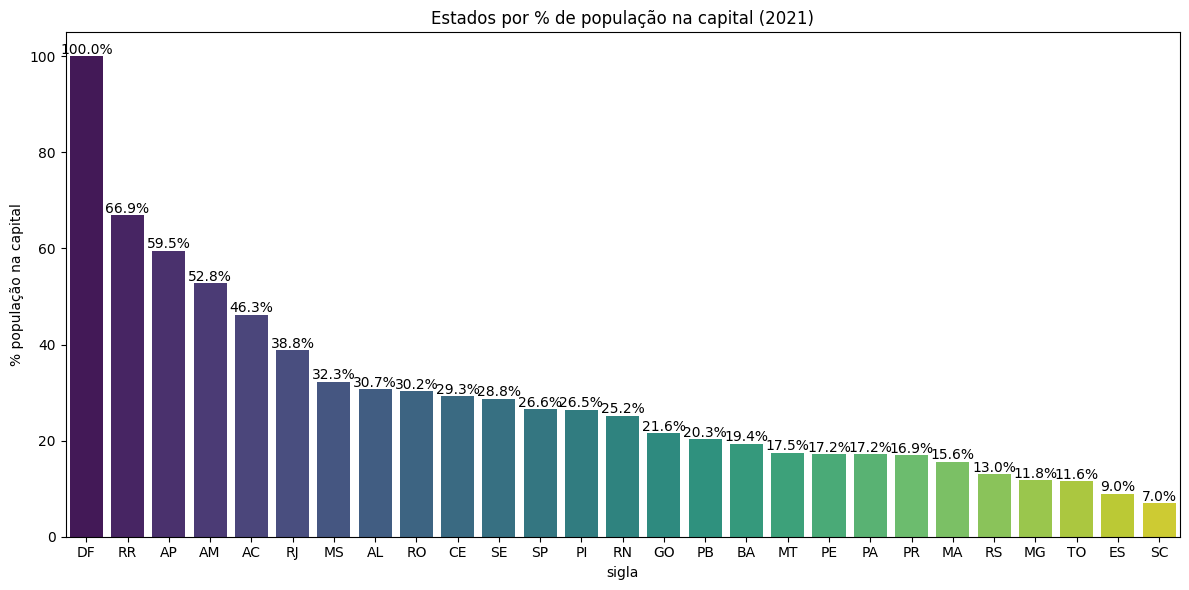

In [26]:
df_pct = df_resultados.copy()
df_pct['pct_capital'] = df_pct['p1'] * 100
top12 = df_pct.sort_values('pct_capital', ascending=False)
plt.figure(figsize=(12,6))
ax = sns.barplot(data=top12, x='sigla', y='pct_capital', hue='sigla', palette='viridis', dodge=False)
legend = ax.get_legend()
if legend:
    legend.remove()
ax.set_ylabel('% população na capital')
ax.set_title('Estados por % de população na capital (2021)')
for i, v in enumerate(top12['pct_capital']):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.show()